Uploading the data file to google drive. This does not need to be executed if running on local anaconda machine.

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving review_text.txt to review_text.txt
User uploaded file "review_text.txt" with length 66033508 bytes


Initalizing the current directory and data file name

In [0]:
import os
file_name='review_text.txt'
current_dir= os.getcwd()

Importing all the relevant packages needed for running the model

In [3]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import numpy as np
import collections
import nltk

Using TensorFlow backend.


Downloading the nltk package for word tokenization

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Processing the data file

In [0]:
max_len = 0
word_freqs = collections.Counter()
num_recs = 0
# DATA_DIR='/Users/gowthamkannan/Desktop/Assignments/Computational_Linguistics/Assignment_2/pos_tagger/data'
# DATA_FILE='dialogues.txt'
ftrain = open(os.path.join(current_dir, file_name), 'rb')
label_list=[]
for line in ftrain:
    words=[]
#     sentence=line.strip().split('\t')[0]
#     label=line.strip().split('\t')[1]
    sentence=line.strip().split(b'DELIMETER')[0]
    label=line.strip().split(b'DELIMETER')[1]
    
#     print(label,sentence)
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    label=label.decode("ascii","ignore").lower()
    label_list.append(label)
#     for item in words_temp:
#         if item not in stopwords_list:
#             words.append(item)
    if len(words) > max_len:
        max_len = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
# print(word_freqs)
label_list=list(set(label_list))
nos_classes=len(label_list)
# print(len(label_list))
ftrain.close()
MAX_FEATURES=5000
MAX_SENTENCE_LENGTH=500

Creating the vocabulary needed for word embedding

In [0]:
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

Creating the input vector and the output label vector

In [9]:
X = np.empty((num_recs, ), dtype=list)
nos_classes=2
y = np.zeros((num_recs, nos_classes))
i = 0
f_train = open(os.path.join(current_dir, file_name), 'rb')
for line in f_train:
#     label,sentence=line.strip().split('\t')
    words=[]
    sentence=line.strip().split(b'DELIMETER')[0]
    label=line.strip().split(b'DELIMETER')[1]
    words = nltk.word_tokenize(sentence.decode("ascii", "ignore").lower())
    label=label.decode("ascii","ignore").lower()
    label_list.append(label)
#     for item in words_temp:
#         if item not in stopwords_list:
#             words.append(item)
    seqs=[]
    l=[0]*nos_classes
    for word in words:
        if word in word2index.keys():
            seqs.append(word2index[word])
        else:
            seqs.append(word2index['UNK'])
    X[i]=seqs
    l[label_list.index(label)]=1
    y[i]=l
    i+=1
f_train.close()
print(MAX_SENTENCE_LENGTH)

X=sequence.pad_sequences(X,maxlen=MAX_SENTENCE_LENGTH)

500


Splitting the dataset for training and testing

In [0]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2)
# print(ytrain.shape)

Initializing the CNN model for movie data sentiment classification

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, MAX_SENTENCE_LENGTH, input_length=MAX_SENTENCE_LENGTH))
model.add(Conv1D(filters=100, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=100, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(filters=32, kernel_size=10, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(nos_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 500)          2501000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 100)          500100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 100)          100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 32)            32032     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 32)             0         
__________

Fitting the model

In [12]:
history=model.fit(Xtrain,ytrain,batch_size=250,epochs=10,validation_data=(Xtest,ytest))
# Final evaluation of the model
scores = model.evaluate(Xtest, ytest, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 56s 1ms/step - loss: 0.4199 - acc: 0.7729 - val_loss: 0.2503 - val_acc: 0.8987
Epoch 2/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.1944 - acc: 0.9237 - val_loss: 0.2384 - val_acc: 0.9038
Epoch 3/10
18500/40000 [============>.................] - ETA: 26s - loss: 0.1466 - acc: 0.9475

40000/40000 [==============================] - 55s 1ms/step - loss: 0.1454 - acc: 0.9469 - val_loss: 0.2428 - val_acc: 0.9081
Epoch 4/10
40000/40000 [==============================] - 55s 1ms/step - loss: 0.0908 - acc: 0.9696 - val_loss: 0.2804 - val_acc: 0.9033
Epoch 5/10
39750/40000 [============================>.] - ETA: 0s - loss: 0.0452 - acc: 0.9864

40000/40000 [==============================] - 55s 1ms/step - loss: 0.0451 - acc: 0.9864 - val_loss: 0.3892 - val_acc: 0.8937
Epoch 6/10
40000/40000 [==============================] - 55s 1ms/step - loss: 0.0241 - acc: 0.9928 - val_loss: 0.4109 - val_acc: 0.9013
Epoch 7/10
28500/40000 [====================>.........] - ETA: 14s - loss: 0.0101 - acc: 0.9969

40000/40000 [==============================] - 55s 1ms/step - loss: 0.0137 - acc: 0.9958 - val_loss: 0.4912 - val_acc: 0.8917
Epoch 8/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.0227 - acc: 0.9919 - val_loss: 0.4756 - val_acc: 0.8995
Epoch 9/10
40000/40000 [==============================] - 54s 1ms/step - loss: 0.0129 - acc: 0.9955 - val_loss: 0.4864 - val_acc: 0.9030
Epoch 10/10
 1250/40000 [..............................] - ETA: 48s - loss: 0.0050 - acc: 0.9984

40000/40000 [==============================] - 54s 1ms/step - loss: 0.0050 - acc: 0.9984 - val_loss: 0.6650 - val_acc: 0.8942
Accuracy: 89.42%


Plotting accuracy and loss function for training and validation dataset

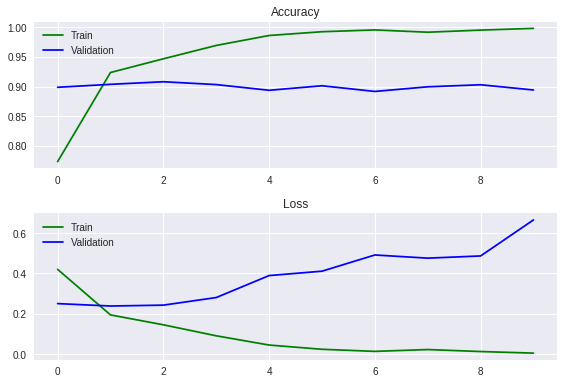

In [13]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Testing the model for new data point.

In [19]:
new_X = np.empty((1, ), dtype=list)
test_sentence="this movie absolutely terrible ..not only was the acting awful but so was the sleep got while this movie played..this movie achieved the all powerful goal of crap ..i watched this movie thinking my 5$ wouldn't b in vein .but i was very wrong ..i guarantee u r better off just reading what i have to say about this unbelievably horrible movie b4 ..puttin yourself in the way of this dignity depriving movie ..i give it a negative 1 for trying..but no please no don't watch this movie..i had friends who joined me for this film..shortly after they were no longer found this movie actually will make u end your life please please don't see it i beg of u. if u see this movie make sure u destroy all copies because this movie is a spawn of Satan."
test_sentence="""It's a strange feeling to sit alone in a theater occupied by parents and their rollicking kids. I felt like instead of a movie ticket, I should have been given a NAMBLA membership.<br /><br />Based upon Thomas Rockwell's respected Book, How To Eat Fried Worms starts like any children's story: moving to a new town. The new kid, fifth grader Billy Forrester was once popular, but has to start anew. Making friends is never easy, especially when the only prospect is Poindexter Adam. Or Erica, who at 4 1/2 feet, is a giant.<br /><br />Further complicating things is Joe the bully. His freckled face and sleeveless shirts are daunting. He antagonizes kids with the Death Ring: a Crackerjack ring that is rumored to kill you if you're punched with it. But not immediately. No, the death ring unleashes a poison that kills you in the eight grade.<br /><br />Joe and his axis of evil welcome Billy by smuggling a handful of slimy worms into his thermos. Once discovered, Billy plays it cool, swearing that he eats worms all the time. Then he throws them at Joe's face. Ewww! To win them over, Billy reluctantly bets that he can eat 10 worms. Fried, boiled, marinated in hot sauce, squashed and spread on a peanut butter sandwich. Each meal is dubbed an exotic name like the "Radioactive Slime Delight," in which the kids finally live out their dream of microwaving a living organism.<br /><br />If you've ever met me, you'll know that I have an uncontrollably hearty laugh. I felt like a creep erupting at a toddler whining that his "dilly dick" hurts. But Fried Worms is wonderfully disgusting. Like a G-rated Farrelly brothers film, it is both vomitous and delightful.<br /><br />Writer/director Bob Dolman is also a savvy storyteller. To raise the stakes the worms must be consumed by 7 pm. In addition Billy holds a dark secret: he has an ultra-sensitive stomach.<br /><br />Dolman also has a keen sense of perspective. With such accuracy, he draws on children's insecurities and tendency to exaggerate mundane dilemmas.<br /><br />If you were to hyperbolize this movie the way kids do their quandaries, you will see that it is essentially about war. Freedom-fighter and freedom-hater use pubescent boys as pawns in proxy wars, only to learn a valuable lesson in unity. International leaders can learn a thing or two about global peacekeeping from Fried Worms.<br /><br />At the end of the film, I was comforted when two chaperoning mothers behind me, looked at each other with befuddlement and agreed, "That was a great movie." Great, now I won't have to register myself in any lawful databases"""
# test_sentence="""It's hard to say sometimes why exactly a film is so effective. From the moment I first came across "The Stone Boy", something told me it would be a great film. In spite of that, it seemed very unlikely that I'd ever have the opportunity to actually see it for myself. Then, one day, while looking through the online catalogue of my local library, I saw that they had recently purchased the DVD release of this film. Which I'm extremely glad for, because the cinematography is of a stunning depth and quality that an old VHS copy could never replicate.<br /><br />And speaking of the cinematography, I must single it out as far and above the most stunning aspect of this film. As a photographer who pursues very nearly the exact visual style portrayed in "The Stone Boy", I'm a firm believer in the fact that a great cinematographer can almost single-handedly carry a film. Here, he has a lot of help from an extremely talented cast, and a director who understands perfectly what the story needs. But to have Juan Ruiz Anchía behind the camera makes virtually every scene something of beauty. And you can almost never say that. Most films would never even expect such a thing of you. Scene after scene captures some detail, some little bit of visual magic that takes your breath away.<br /><br />The director, Christopher Cain, has had a long and interesting career. As far as I can gather, this film is not very representative of it. But, sometimes, to catch a director near the beginnings of his career, before all the big budgets and loss of focus, there's a real subtle magic to be found. Cain steps back in this film, lets things happen with a life of their own, and then ever further. Much like early John Sayles films, characters are given space to breathe, time to talk. Side stories happen because they do, and that's how life is. Cain displays a remarkable, raw, even outright painful understanding of human nature in this film.<br /><br />The acting ties much of this story together. When people talk, when they exist in this film, they do so as actual people, not held back by the fact that they are playing characters. Gina Berriault's script allows immensely talented and respected actors like Wilford Brimley, Robert Duvall, Glenn Close, and Frederic Forrest to spend time simply existing. Whether the things they have to say are minor or of deep significance, it all comes down with the weight of pure reality.<br /><br />When you look at the actors involved, or the great soundtrack by James Horner, it seems strange that such a film be very nearly forgotten. Maybe much of what makes "The Stone Boy" what it is was the time period it was made in. There's this 1970s hangover feeling to this picture that reminds me deeply of my own childhood. People talk of the 80s in terms of modern styles and music, but that's not the 80s I lived in or remember. The look of the images, the understated and dark knowing quality of the acting, and the overall result should get under the skin of any person who grew up in or near this era of time in North America. I see myself in this. I see how I saw the world. And a film like "The Stone Boy" sees the world for how it truly is.<br /><br />For more of this feeling, please see:<br /><br />The Black Stallion (1979), Never Cry Wolf (1983), Tender Mercies (1983), Testament (1983), Places in the Heart (1984), Matewan (1987), High Tide (1987), Driving Miss Daisy (1989), The Secret Garden (1993), The Secret of Roan Inish (1994), Wendy and Lucy (2008)"""
# test_sentence="""A typical romp through Cheech and Chong's reality which includes drugs, singing, more drugs, cars and driving, even more drugs, Pee Wee, aliens, gasoline, laundry, stand up comedy, surprisingly more drugs and SPACE COKE !!. It is not as coherent or plausible as Up in Smoke but it still is incredibly funny, without becoming as strange as Nice Dreams. There are some classic scenes, which include the opening scene where they get some gas for their car and the drive to work. Also funny is Cheech's song (Mexican-Americans) and Chong's follow up song. Another notable scene is the welfare office scene with Jones (human noise machine), from the Police Academy series, and the old laughing man. All in all, this is a great follow up to Up in Smoke and is quite watchable when sober or not.<br /><br />-Celluloid RehabDELIMETER1
# OK heres what I say: <br /><br />The movie was excellent. I am a huge Nancy fan and I have read all 1-56 original books and I went on to read more. I am now on 96. Beware of villains giving this movie a lower grade than it should have. All clues point to a wonderful movie! I loved the whole thing. So what Nancy is in current time. She is still old fashioned like she is in the books! People who haven't read more than 5 books are complaining about the view of Nancy. I have read all of them and I think Emma is perfect and that Nancy was perfect. I found parts of the movie spooky. I loved the exciting car chases and get aways. I loved the clues. I solved the mystery myself! It was really wonderful. I suggest you go see it since people who have been complaining know nothing of A what a good movie is and B about Nancy Drew. Go see it. It may not be Oscar worthy but its really a good movie"""
# test_sentence="""I wrote spoiler alert, but there's not really much that can be spoiled. It's like spoiling rotten meat. This movie is probably the worst I've ever seen. Not because of the actors or the special effects, but because of the sheer number of mistakes, both factual and physical. First of all, the MIGs aren't actually MIGs at all. They're Mirages, and they're French. And how the heck can Doug's dad withstand the maneuvers his son makes to fight off the "MIGs" without a g-suit? And why would Chappy try to board his plane without a g-suit? And how could Doug defeat the enemy pilot ace with such ease? Anyway, I did not like this movie. And the worst part is that it has 3 sequels, the latest one from as late as 1995. Now that's scary."""

test_sentence=""" The movie was terrilbe"""
seqs=[]

for word in test_sentence.split():
    if word in word2index.keys():
      seqs.append(word2index[word])
    else:
      seqs.append(word2index['UNK'])
# print(seqs)
new_X[0]=seqs
new_X=sequence.pad_sequences(new_X,maxlen=MAX_SENTENCE_LENGTH)
y=model.predict(new_X)
label=label_list[np.argmax(y)]
print(label)

0
